In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
import torch

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
Filtering raw data in 40 contiguous segments
Setting up band-pass filter from 0.05 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 10561 samples (66.006 sec)

Fitting ICA 

C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 161.3s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
2452 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
2452 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


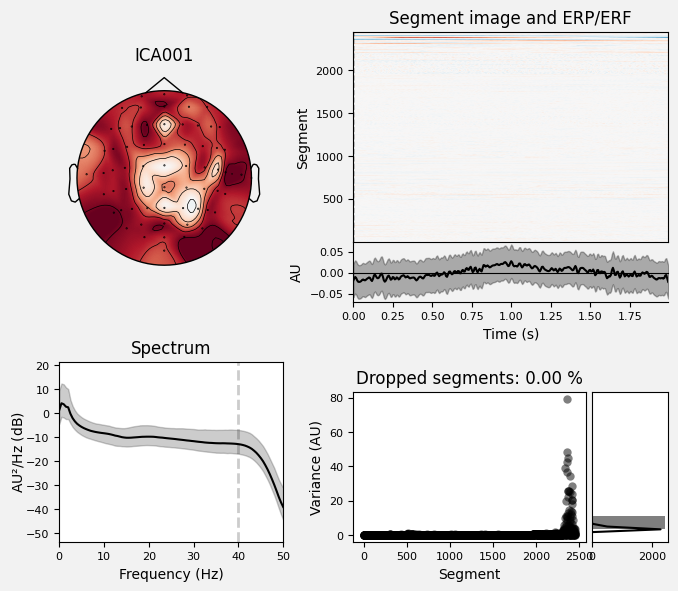

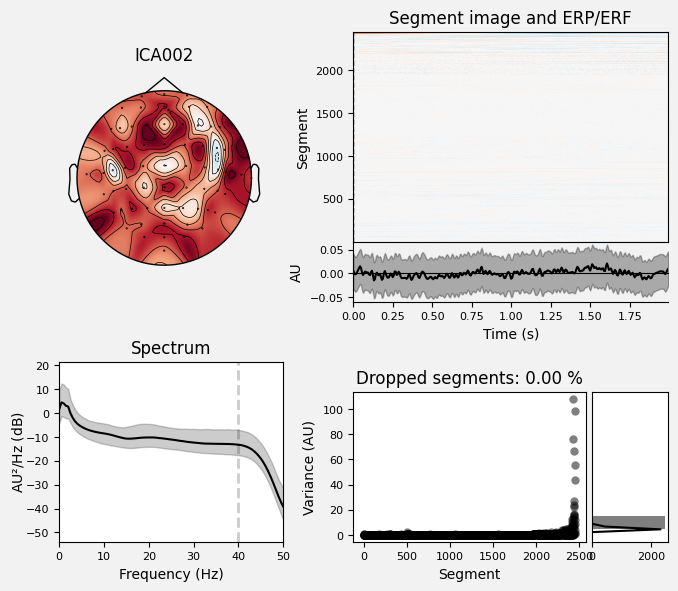

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Loading data for 600 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
Filtering raw data in 20 contiguous segments
Setting up band-pass filter from 0.05 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 72.5s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1226 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1226 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


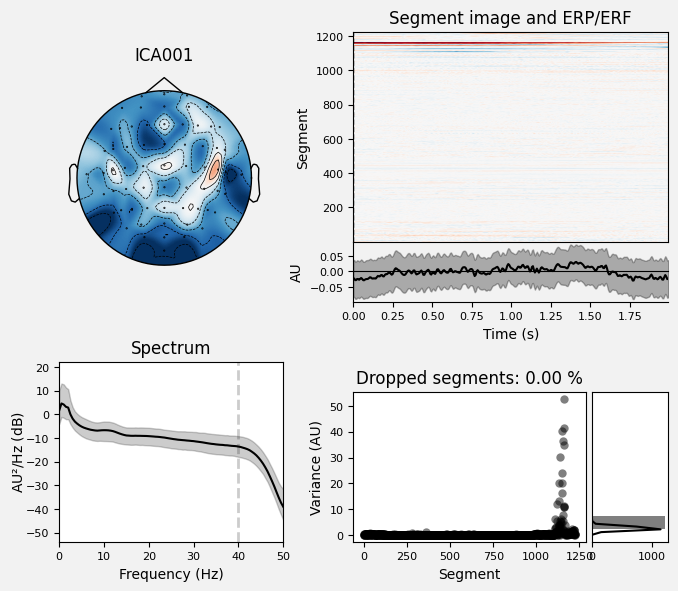

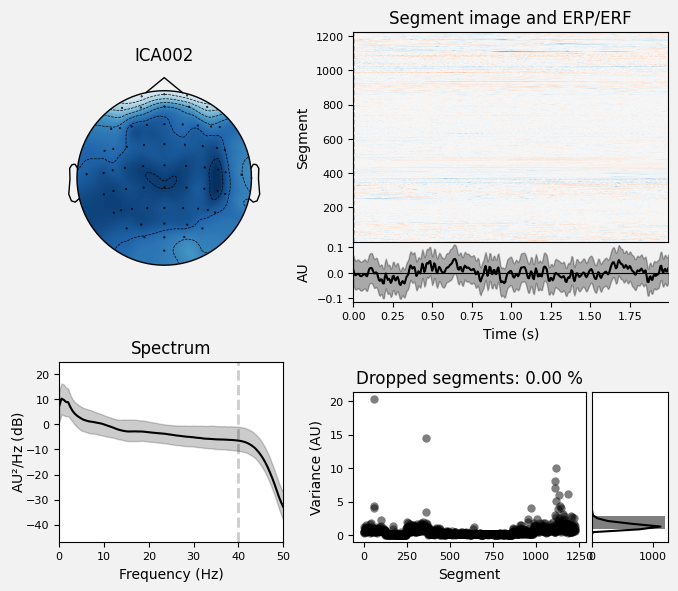

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 641 original time points ...
0 bad epochs dropped


In [3]:

def get_physio():
    subject =['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
    path = "dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0"
    folders = os.listdir(path)
    subject_count = 0
    train_path = []
    valid_path = []
    count = 0
    for fol in folders:
        if count == 10:
            break
        else:
            count +=1
        for i in range (len (subject)):
            if  subject[i] in ['01','02','05','06','09','10','13','14']:
                pass
            elif subject[i] in ['03','04','07','08']:
                file = "dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\{}\\{}R{}.edf".format(fol,fol, subject[i])
                train_path.append(file)
            elif subject[i] in ['11','12']:
                file = "dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\{}\\{}R{}.edf".format(fol,fol, subject[i])
                valid_path.append(file)
            
  
    return valid_path,train_path

def get_epoch(data_path,tmin,tmax,event_id,preprocess=False,ica=False):
    
    raw = concatenate_raws([read_raw_edf(f, preload=True,verbose='WARNING') for f in data_path])
    
    raw_data = raw.copy()
    eegbci.standardize(raw_data)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw_data.set_montage(montage)
    raw_data.rename_channels(lambda x: x.strip('.'))
    print(raw_data.info['ch_names'])
    
    
    # Apply band-pass filter
    if preprocess == True:
        raw_data.filter(l_freq=0.05, h_freq=40.,fir_design='firwin', verbose=20)
        raw_data.notch_filter(60,filter_length='auto', phase='zero')
    if ica == True:
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw_data)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw_data, picks=ica.exclude)
        ica.apply(raw_data)
            
    raw_data.pick_channels(['FC1','FC2'])    
    events, event_id = events_from_annotations(raw_data,event_id=event_id)
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    reject_criteria = dict(eeg=100e-6)  #most frequency in this range is not brain components
    
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    labels = epochs.events[:, -1]
    return epochs.get_data(),labels,epochs,raw_data
    
def get_data():
    valid_path, train_path = get_physio()
        
    #tmin, tmax = -0.2, 0.4
    tmin, tmax = 0, 4
    event_id = dict(T1=0, T2=1)

    train_epoch,train_labels,raw_epoch,raw = get_epoch(train_path,tmin,tmax,event_id,True,True)
    valid_epoch,valid_labels,_,_ = get_epoch(valid_path,tmin,tmax,event_id,True,True)
    
    return train_epoch,train_labels,valid_epoch,valid_labels,raw_epoch,raw

#train_epoch,valid_epoch,train_labels,valid_labels,raw_epoch,raw= get_data()
train_epoch,train_labels,valid_epoch,valid_labels,raw_epoch,raw= get_data()

In [4]:
# 100068 events(epoch)
# 64 channel
# 961 Time(samples)
#(event,channel,time)
print(train_epoch.shape)
print(train_labels.shape)
print('---------------')
#print(valid_epoch.shape)
#print(valid_labels.shape)
X = train_epoch[:, np.newaxis,:,:]
y = train_labels
print(X.shape)
print(train_epoch.shape[1])
print(train_labels)
print(raw.info['ch_names'])
print(raw.info['nchan'])

(600, 2, 641)
(600,)
---------------
(600, 1, 2, 641)
2
[1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0
 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0
 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0

In [ ]:
'''import pickle
valid , train = get_physio()
filename = 'validpath'
outfile = open(filename,'wb')
pickle.dump(valid,outfile)
outfile.close()
infile = open(filename,'rb')
new = pickle.load(infile)'''


In [5]:
#10614 data,64 channel,161 timesamples

X_t,y_train= train_epoch.copy(),train_labels

X_val,y_valid = valid_epoch.copy(),valid_labels
'''X = X[:, np.newaxis,:,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)'''
#add new dimension
X_train = X_t[:, np.newaxis,:,:]
X_valid = X_val[:,np.newaxis,:,:]
#X_valid = X_valid[:,np.newaxis,:,:]
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))



(600, 1, 2, 641)
(600,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import TensorDataset


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.temporal= nn.Conv1d(in_channels=2,out_channels=25,kernel_size=1,stride=1,padding=1)
        
        self.spatial = nn.Conv1d(in_channels=25,out_channels=25,kernel_size=25,stride=1,padding=1)
        self.batchnorm1 = nn.BatchNorm1d(25,False)
        self.maxPooling = nn.MaxPool1d(3)
        
        self.conv3 = nn.Conv1d(in_channels=25,out_channels=50,kernel_size=11,stride=1,padding=1)
        self.conv4 = nn.Conv1d(in_channels=50,out_channels=100,kernel_size=11,stride=1,padding=1)
        self.batchnorm2 = nn.BatchNorm1d(100,False)
        
        self.conv5 = nn.Conv1d(in_channels=100,out_channels=200,kernel_size=11,stride=1,padding=1)
        self.batchnorm3 = nn.BatchNorm1d(200,False)
        self.maxPooling2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fully = nn.Linear(1000,2) 
        
    def forward(self,x):
        #print(x.shape)
        x = self.temporal(x)
        #print('Temporal: '+str(x.shape))
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        #print('Dropout: '+str(x.shape))
        
        x = self.spatial(x)
        #print('Spatial: '+str(x.shape))
        x = self.batchnorm1(x)
        #print('Batchnorm: '+str(x.shape))
        x = F.leaky_relu(x)
        x = self.maxPooling(x)
        #print('Max pooling: '+str(x.shape))
        
        x = self.conv3(x)
        #print('Convo3 : '+str(x.shape))
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        x = self.maxPooling(x)
        #rint('Max pooling : '+str(x.shape))
        
        x = self.conv4(x)
        #print('Convo4 : '+str(x.shape))
        x = self.batchnorm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        #print('Dropout: '+str(x.shape))
        x = self.maxPooling(x)
        #print('Max pooling : '+str(x.shape))
        
        x = self.conv5(x)
        #print('Convo5 : '+str(x.shape))
        x = self.batchnorm3(x)
        x = F.leaky_relu(x)
        x = self.maxPooling2(x)
        #print('Max pooling 2 : '+str(x.shape))
        x = self.flatten(x)
        #print('Flatten : '+str(x.shape))
        out = self.fully(x)
        return out

In [8]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 1 will be of shape [32, 16, 32, 80]
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 2 will be of shape [100, 32, 16, 40]
        self.fc = nn.Linear(20480, 2)
        self.drop_out = nn.Dropout(0.5)  #zeroed 0.2% data
        #after fc will be of shape [100, 10]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        #[32, 1, 64, 161]
        out = self.layer1(x)
        out = self.drop_out(out)
        #after layer 1: shape: [32, 16, 32, 80]
        #out = self.layer2(out)
        #out = self.drop_out(out)
        #after layer 2: shape: [100, 32, 16, 40]
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #after squeezing: shape: [32, 20480]
        #we squeeze so that it can be inputted into the fc layer
        #print(out.shape)
        out = self.fc(out)
        #after fc layer: shape: [32, 2]
        return out

In [9]:
batch_size = 32
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

train_iterator = create_dataloader(X_train, y_train, batch_size=batch_size)
valid_iterator = create_dataloader(X_valid, y_valid, batch_size=batch_size)


In [10]:
'''X_torch = torch.from_numpy(X_train).double()
y_torch = torch.from_numpy(y_train).long()
train_set = TensorDataset(X_torch, y_torch)
#valid_set = TensorDataset(torch.from_numpy(X_valid).double(),torch.from_numpy(y_valid).long())

BATCH_SIZE = 32
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
'''

'X_torch = torch.from_numpy(X_train).double()\ny_torch = torch.from_numpy(y_train).long()\ntrain_set = TensorDataset(X_torch, y_torch)\n#valid_set = TensorDataset(torch.from_numpy(X_valid).double(),torch.from_numpy(y_valid).long())\n\nBATCH_SIZE = 32\ntrain_iterator = torch.utils.data.DataLoader(dataset=train_set, \n                                           batch_size=BATCH_SIZE, \n                                           shuffle=True)\n\nvalid_iterator = torch.utils.data.DataLoader(dataset=valid_set, \n                                           batch_size=BATCH_SIZE, \n                                           shuffle=True)\n'

In [11]:
device = 'cuda'
#model = CNN()
model = ConvNet()

In [12]:
'''for i, (x,y) in enumerate(train_iterator):
    x = x.to(device=device,dtype=torch.float32)
    model.to(device=device) 
    print(x.shape)
    #model(x)
    
    break'''


'for i, (x,y) in enumerate(train_iterator):\n    x = x.to(device=device,dtype=torch.float32)\n    model.to(device=device) \n    print(x.shape)\n    #model(x)\n    \n    break'

In [13]:
# Train
from common import train

lr = 0.00001
n_epochs = 2000
patience = 200
#,weight_decay=1e-2
weight_name = "Physionet_ConvNet_10subjectOldtrainset_leaky_Fc1Fc2_UseICA&standardize_executedImagine_Newtrain"
model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

best_model,train_loss,valid_loss,train_acc,valid_acc = train(model, train_iterator, valid_iterator, optimizer,criterion,n_epochs,device,weight_name)


Starting epoch 1 / 2000


C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/2000, Tr Loss: 0.6930, Tr Acc: 52.6667, Val Loss: 0.6937, Val Acc: 51.0000

Starting epoch 2 / 2000
Epoch 2/2000, Tr Loss: 0.6927, Tr Acc: 53.8333, Val Loss: 0.6929, Val Acc: 51.0000

Starting epoch 3 / 2000
Epoch 3/2000, Tr Loss: 0.6925, Tr Acc: 56.5000, Val Loss: 0.6930, Val Acc: 51.0000

Starting epoch 4 / 2000
Epoch 4/2000, Tr Loss: 0.6924, Tr Acc: 58.3333, Val Loss: 0.6931, Val Acc: 53.3333

Starting epoch 5 / 2000
Epoch 5/2000, Tr Loss: 0.6925, Tr Acc: 58.8333, Val Loss: 0.6928, Val Acc: 58.0000

Starting epoch 6 / 2000
Epoch 6/2000, Tr Loss: 0.6922, Tr Acc: 57.5000, Val Loss: 0.6923, Val Acc: 53.0000

Starting epoch 7 / 2000
Epoch 7/2000, Tr Loss: 0.6921, Tr Acc: 59.0000, Val Loss: 0.6922, Val Acc: 54.0000

Starting epoch 8 / 2000
Epoch 8/2000, Tr Loss: 0.6920, Tr Acc: 60.0000, Val Loss: 0.6923, Val Acc: 56.3333

Starting epoch 9 / 2000
Epoch 9/2000, Tr Loss: 0.6917, Tr Acc: 59.1667, Val Loss: 0.6920, Val Acc: 54.3333

Starting epoch 10 / 2000
Epoch 10/2000, Tr Loss: 0.6

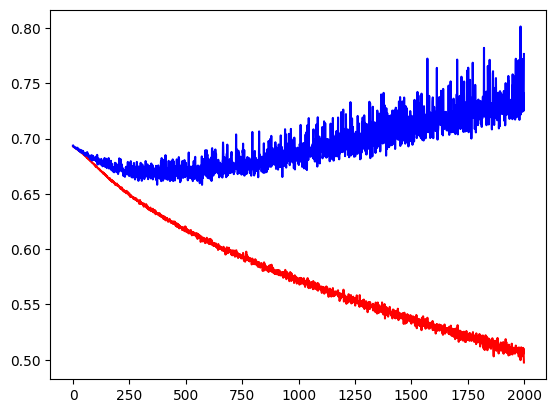

Train loss0.4975466649783285
Valid loss0.6581624567508697


In [14]:
def do_plot(train_loss, valid_loss):
    plt.figure(figsize=(10,10))
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()

import matplotlib.pyplot as plt
plt.plot(train_loss,'r')
plt.plot(valid_loss,'b')
plt.show()
print("Train loss" + str(min(train_loss)))
print("Valid loss" + str(min(valid_loss)))

In [15]:
import math
print('Train acc: '+ str(train_acc[-1].item()))
print(max(train_acc).item())
print(sum(train_acc).item()/len(train_acc))

print('Valid acc:' + str(valid_acc[-1].item()))
print(max(valid_acc).item())
print(sum(valid_acc).item()/len(valid_acc))

Train acc: 78.0
78.5
72.2709140625
Valid acc:61.66666666666667
65.33333333333333
62.16883333333333
